# Capstone Final Submission

## Introduction & Business Problem

The final submission for the capstone project can be split into two seperate questions.

# Question 1 - Toronto & Ottawa

Objective: to compare the neighbourhoods of Toronto and Ottawa and determine how similar or dissimilar they are. This will inform a project currently being worked by the Government of Canada.

Target audience: Analysts within the Government of Canada
Stakeholders: Government of Canada

Using the Foursquare API I will explore the most common venue categories in Downtown Toronto and Ottawa, then use this feature to group the neighbourhoods into clusters – using K means. After which I will use the Folium library to visualise the neighbourhoods in both Toronto and Ottawa along with their emerging venue clusters. This information will benefit the Government of Canada as they are attempting to establish the diversity of venue types in these locations.


# Question 2 - Italian Restaurants in Toronto

Objective: A restaurant owner is looking to open a new Italian restaurant in Toronto, the objective is to recommend the best location to open the venue.

Target audience: restaurant owner
Stakeholders: the bank (who is lending the restaurant owner the money to open the restaurant)

Using the Foursquare API I will explore the Italian restaurants in each neighbourhood in Toronto. After which I will use the Folium library to visualise the restaurants in order to inform the owner of the current distribution. The spatial distribution is highly important from a competition point of view as an area highly saturated in italian cusinine will prove detremental to their business.
Therefore the owner will be looking for an area that has none/few italian restaurants at present.

##### Loading packages:

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
!conda install -c conda-forge lxml --yes
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.12.5          |   py36h5fab9bb_1         143 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         240 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0

The following packages will be UPDATED:

  certifi                          2020.12.5-py36h5fab9bb_0 --> 2020.12.5-py36h5fab9bb_1



geopy-2.1.0          | 64 KB     

# Question 1 - Toronto & Ottawa

Objective: to compare the neighbourhoods of Toronto and Ottawa and determine how similar or dissimilar they are. This will inform a project currently being worked by the Government of Canada.

##### Loading the Toronto and Ottawa data into two seperate pandas dataframes:

In [2]:
# loading toronto wiki table of postcodes
df1 = pd.read_csv('postal_codes_of_canada.csv')

# Dropping the Borough rows that contain the value "Not assigned"
df1 = df1[df1.Borough != "Not assigned"]

# loading csv file of cooordinates
coords_df = pd.read_csv("Geospatial_Coordinates.csv")
coords_df.head()

#merging the two dataframes into a single df_toronto - using the Postal Code.
df_toronto = pd.merge(df1,coords_df,on="Postal Code")
# filtering the df to only include boroughs that contain the word "toronto".
df_toronto = df_toronto[df_toronto['Borough'].str.contains("Toronto")]

#renaming neighborhood column
df_toronto.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)
df_toronto.head(3)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
15,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
17,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
18,M6S,West Toronto,"Runnymede, Swansea",43.651571,-79.484450


In [3]:
df_toronto.shape

(39, 5)

In [4]:
df_toronto.describe()

,Latitude,Longitude
count,39.000000,39.000000
mean,43.667135,-79.389873
std,0.023478,0.037451
min,43.628947,-79.484450
25%,43.649765,-79.405678
50%,43.662301,-79.387383
75%,43.677957,-79.376474
max,43.728020,-79.293031


In [5]:
df_toronto.dtypes

Postal Code      object
Borough          object
Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

In [6]:
# loading otawa geospatial data
df_ottawa = pd.read_csv('ottawa_geospatial.csv')

#renaming neighborhood column
df_ottawa.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)
df_ottawa.head(3)

,Postal Code,City,Neighborhood,Latitude,Longitude
0,K2A,Ottawa,"Highland Park, McKellar Park,Westboro, Glabar ...",45.195828,-75.823060
1,K4A,Ottawa,Fallingbrook,45.449549,-75.476860
2,K1B,Ottawa,"Blackburn Hamlet, Pine View, Sheffield Glen",45.416035,-75.621899


In [7]:
df_ottawa.shape

(40, 5)

In [8]:
df_ottawa.describe()

,Latitude,Longitude
count,40.000000,40.000000
mean,45.334415,-75.750297
std,0.193601,0.244767
min,44.249605,-76.955967
25%,45.298361,-75.823060
50%,45.360518,-75.696435
75%,45.422508,-75.627695
max,45.505467,-75.472889


In [9]:
df_ottawa.dtypes

Postal Code      object
City             object
Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

##### Visualizing the Toronto and Ottawa data on maps:

In [10]:
# creating a map of toronto with neighbourhoods on top of it.
map_toronto = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

for lat,lng,borough,neighbourhood in zip(df_toronto['Latitude'],df_toronto['Longitude'],df_toronto['Borough'],df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)
map_toronto

In [11]:
# creating a map of ottawa with neighbourhoods on top of it.
map_ottawa = folium.Map(location=[45.449549,-75.476860],zoom_start=10)

for lat,lng,neighbourhood in zip(df_ottawa['Latitude'],df_ottawa['Longitude'],df_ottawa['Neighborhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_ottawa)
map_ottawa

### Focusing on the Toronto dataset
#### Simplifying the Toronto data to cluster only the neighborhoods in Downtown Toronto

In [12]:
toronto_downtown_data = df_toronto[df_toronto["Borough"]=="Downtown Toronto"].reset_index(drop=True)
toronto_downtown_data.head(10)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
1,M6G,Downtown Toronto,Christie,43.669542,-79.422564
2,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280
3,M5W,Downtown Toronto,Stn A PO Boxes,43.646435,-79.374846
4,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420
5,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049
6,M5S,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049
7,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817
8,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576
9,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752


#### Exploring the first neighborhood in the Toronto dataframe

In [13]:
toronto_downtown_data.loc[0,"Neighborhood"]

"Queen's Park, Ontario Provincial Government"

In [14]:
neighborhood_latitude = toronto_downtown_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_downtown_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_downtown_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Queen's Park, Ontario Provincial Government are 43.6623015, -79.3894938.


#### Define Foursquare credentials

In [15]:
CLIENT_ID = 'XBAJLFUBKHRRDCJOZ3PGS4R2EOIDLVOGMCX5PKJJK3HXXQHN' # your Foursquare ID
CLIENT_SECRET = 'XCXXBLEAC1JRK1TA2URBNDK2INZO4VT5RIZB0EUUBU2ALIDX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XBAJLFUBKHRRDCJOZ3PGS4R2EOIDLVOGMCX5PKJJK3HXXQHN
CLIENT_SECRET:XCXXBLEAC1JRK1TA2URBNDK2INZO4VT5RIZB0EUUBU2ALIDX


#### Exploring the top 100 venues that are in Queen's Park within a radius of 500 meters.

In [16]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=XBAJLFUBKHRRDCJOZ3PGS4R2EOIDLVOGMCX5PKJJK3HXXQHN&client_secret=XCXXBLEAC1JRK1TA2URBNDK2INZO4VT5RIZB0EUUBU2ALIDX&v=20180605&ll=43.6623015,-79.3894938&radius=500&limit=100'

In [17]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '602ba23f483975334d575fb9'},
 'response': {'headerLocation': 'Bay Street Corridor',
  'headerFullLocation': 'Bay Street Corridor, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 32,
  'suggestedBounds': {'ne': {'lat': 43.6668015045, 'lng': -79.38328496866619},
   'sw': {'lat': 43.657801495499996, 'lng': -79.3957026313338}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b9d206bf964a520e69136e3',
       'name': "Queen's Park",
       'location': {'address': 'University Ave.',
        'crossStreet': 'at Wellesley Ave.',
        'lat': 43.66394609897775,
        'lng': -79.39217952520835,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.66394609897775,
          'lng': -79.39217952520835}],


 #### Borrowing the get_category_type function from the Foursquare lab.

In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [19]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Queen's Park,Park,43.663946,-79.392180
1,Mercatto,Italian Restaurant,43.660391,-79.387664
2,NEO COFFEE BAR,Coffee Shop,43.660130,-79.385830
3,Central YMCA,Distribution Center,43.663083,-79.385025
4,T-Swirl Crepe,Creperie,43.663452,-79.384125


In [20]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

32 venues were returned by Foursquare.


#### Exploring the neighborhoods in Downtown Toronto

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
toronto_downtown_venues = getNearbyVenues(names=toronto_downtown_data['Neighborhood'],
                                   latitudes=toronto_downtown_data['Latitude'],
                                   longitudes=toronto_downtown_data['Longitude']
                                  )

Queen's Park, Ontario Provincial Government
Christie
First Canadian Place, Underground city
Stn A PO Boxes
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Kensington Market, Chinatown, Grange Park
University of Toronto, Harbord
Commerce Court, Victoria Hotel
Toronto Dominion Centre, Design Exchange
Harbourfront East, Union Station, Toronto Islands
Richmond, Adelaide, King
Central Bay Street
Berczy Park
St. James Town
Garden District, Ryerson
Regent Park, Harbourfront
Church and Wellesley
St. James Town, Cabbagetown
Rosedale


In [23]:
print(toronto_downtown_venues.shape)
toronto_downtown_venues.head()

(1225, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Queen's Park,43.663946,-79.392180,Park
1,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Mercatto,43.660391,-79.387664,Italian Restaurant
2,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,NEO COFFEE BAR,43.660130,-79.385830,Coffee Shop
3,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Central YMCA,43.663083,-79.385025,Distribution Center
4,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,T-Swirl Crepe,43.663452,-79.384125,Creperie


#### Grouping venues in Downtown Toronto by neighborhood

In [24]:
toronto_downtown_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,55,55,55,55,55,55
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17
Central Bay Street,62,62,62,62,62,62
Christie,16,16,16,16,16,16
Church and Wellesley,79,79,79,79,79,79
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
"First Canadian Place, Underground city",100,100,100,100,100,100
"Garden District, Ryerson",100,100,100,100,100,100
"Harbourfront East, Union Station, Toronto Islands",100,100,100,100,100,100


In [25]:
print('There are {} uniques categories.'.format(len(toronto_downtown_venues['Venue Category'].unique())))

There are 212 uniques categories.


#### Analyzing each neighborhood in Downtown Toronto

In [26]:
# one hot encoding
downtown_toronto_onehot = pd.get_dummies(toronto_downtown_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
downtown_toronto_onehot['Neighborhood'] = toronto_downtown_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [downtown_toronto_onehot.columns[-1]] + list(downtown_toronto_onehot.columns[:-1])
downtown_toronto_onehot = downtown_toronto_onehot[fixed_columns]

downtown_toronto_onehot.head(3)

,Yoga Studio,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Cable Car,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Queen's Park, Ontario Provincial Government",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Queen's Park, Ontario Provincial Government",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [27]:
col = downtown_toronto_onehot.pop("Neighborhood")
downtown_toronto_onehot.insert(0, col.name, col)
downtown_toronto_onehot.head(3)

,Neighborhood,Yoga Studio,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Cable Car,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,"Queen's Park, Ontario Provincial Government",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Queen's Park, Ontario Provincial Government",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Queen's Park, Ontario Provincial Government",0,0,

In [28]:
downtown_toronto_onehot.shape

(1225, 212)

 #### Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [29]:
downtown_toronto_grouped = downtown_toronto_onehot.groupby('Neighborhood').mean().reset_index()
downtown_toronto_grouped

,Neighborhood,Yoga Studio,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Cable Car,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.018182,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.018182,0.036364,0.000000,0.000000,0.00,0.018182,0.018182,0.000000,0.036364,0.000000,0.000000,0.018182,0.000000,0.000000,0.000000,0.000000,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018182,0.0000,0.000000,0.036364,0.000000,0.000000,0.000000,0.018182,0.054545,0.090909,0.000000,0.00000,0.00000,0.000000,0.00,0.000000,0.018182,0.000000,0.018182,0.000000,0.000000,0.018182,0.000000,0.000000,0.000000,0.018182,0.000000,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018182,0.000000,0.000000,0.000000,0.000000,0.036364,0.000000,0.000000,0.018182,0.000000,0.000000,0.000000,0.000000,0.018182,0.018182,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.018182,0.018182,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [30]:
downtown_toronto_grouped.shape

(19, 212)

#### Printing each neighborhood in Downtown Toronto along with the top 5 most common venues

In [31]:
num_top_venues = 5

for hood in downtown_toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = downtown_toronto_grouped[downtown_toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1        Cocktail Bar  0.05
2      Farmers Market  0.04
3  Seafood Restaurant  0.04
4              Bakery  0.04


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0    Airport Lounge  0.12
1   Airport Service  0.12
2  Airport Terminal  0.12
3       Coffee Shop  0.06
4             Plane  0.06


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.18
1  Italian Restaurant  0.06
2      Sandwich Place  0.05
3                Café  0.05
4     Bubble Tea Shop  0.03


----Christie----
           venue  freq
0  Grocery Store  0.25
1           Café  0.19
2           Park  0.12
3      Nightclub  0.06
4     Restaurant  0.06


----Church and Wellesley----
                 venue  freq
0          Coffee Shop  0.09
1     Sushi Restaurant  0.06
2  Japanese Restaurant  0.06
3           Restaurant  0.04
4        

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Defining a new dataframe and displaying the top 10 venues for each neighborhood within Downtown Toronto

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
downtown_toronto_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
downtown_toronto_neighborhoods_venues_sorted['Neighborhood'] = downtown_toronto_grouped['Neighborhood']

for ind in np.arange(downtown_toronto_grouped.shape[0]):
    downtown_toronto_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(downtown_toronto_grouped.iloc[ind, :], num_top_venues)

downtown_toronto_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Farmers Market,Seafood Restaurant,Restaurant,Bakery,Beer Bar,Hotel,Eastern European Restaurant
1,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Boutique,Sculpture Garden,Plane,Rental Car Location,Coffee Shop,Bar,Harbor / Marina
2,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Salad Place,Bubble Tea Shop,Burger Joint,Comic Shop,Restaurant,Portuguese Restaurant
3,Christie,Grocery Store,Café,Park,Nightclub,Coffee Shop,Restaurant,Italian Restaurant,Candy Store,Athletics & Sports,Baby Store
4,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Yoga Studio,Men's Store,Mediterranean Restaurant,Hotel,Fast Food Restaurant


#### Clustering the Downtown Toronto Neighborhoods

In [34]:
# set number of clusters
kclusters = 6

downtown_toronto_grouped_clustering = downtown_toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(downtown_toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 3, 4, 2, 4, 0, 0, 4, 4, 5], dtype=int32)

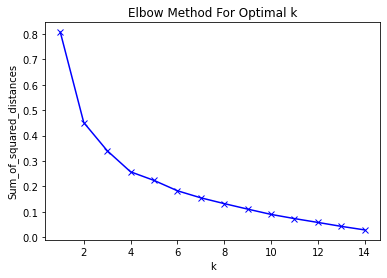

In [35]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
mms = MinMaxScaler()
mms.fit(downtown_toronto_grouped_clustering)
data_transformed = mms.transform(downtown_toronto_grouped_clustering)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(downtown_toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [36]:
# add clustering labels
downtown_toronto_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

downtown_toronto_merged = toronto_downtown_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
downtown_toronto_merged = downtown_toronto_merged.join(downtown_toronto_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

downtown_toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,4,Coffee Shop,Sushi Restaurant,Yoga Studio,Diner,Smoothie Shop,Italian Restaurant,Japanese Restaurant,Beer Bar,Sandwich Place,Restaurant
1,M6G,Downtown Toronto,Christie,43.669542,-79.422564,2,Grocery Store,Café,Park,Nightclub,Coffee Shop,Restaurant,Italian Restaurant,Candy Store,Athletics & Sports,Baby Store
2,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,0,Coffee Shop,Café,Hotel,Restaurant,Japanese Restaurant,Gym,Steakhouse,American Restaurant,Seafood Restaurant,Deli / Bodega
3,M5W,Downtown Toronto,Stn A PO Boxes,43.646435,-79.374846,4,Coffee Shop,Seafood Restaurant,Cocktail Bar,Hotel,Restaurant,Beer Bar,Italian Restaurant,Japanese Restaurant,Café,Sandwich Place
4,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420,3,Airport Lounge,Airport Service,Airport Terminal,Boutique,Sculpture Garden,Plane,Rental Car Location,Coffee Shop,Bar,Harbor / Marina


In [37]:
# create map
downtown_toronto_map_clusters = folium.Map(location=[43.651070,-79.347015], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(downtown_toronto_merged['Latitude'], downtown_toronto_merged['Longitude'], downtown_toronto_merged['Neighborhood'], downtown_toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(downtown_toronto_map_clusters)
       
downtown_toronto_map_clusters

#### Examining the clusters in Downtown Toronto

In [38]:
# cluster 1
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 0, downtown_toronto_merged.columns[[1] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,0,Coffee Shop,Café,Hotel,Restaurant,Japanese Restaurant,Gym,Steakhouse,American Restaurant,Seafood Restaurant,Deli / Bodega
7,Downtown Toronto,0,Coffee Shop,Restaurant,Hotel,Café,American Restaurant,Italian Restaurant,Gym,Japanese Restaurant,Deli / Bodega,Cocktail Bar
8,Downtown Toronto,0,Coffee Shop,Hotel,Café,Japanese Restaurant,American Restaurant,Seafood Restaurant,Restaurant,Italian Restaurant,Salad Place,Bakery
10,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Gym,Bakery,Clothing Store,Thai Restaurant,Deli / Bodega,Lounge,Sushi Restaurant


In [39]:
# cluster 2
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 1, downtown_toronto_merged.columns[[1] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Downtown Toronto,1,Park,Trail,Playground,Cupcake Shop,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store,Diner


In [40]:
# cluster 3
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 2, downtown_toronto_merged.columns[[1] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Downtown Toronto,2,Grocery Store,Café,Park,Nightclub,Coffee Shop,Restaurant,Italian Restaurant,Candy Store,Athletics & Sports,Baby Store


In [41]:
# cluster 4
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 3, downtown_toronto_merged.columns[[1] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Downtown Toronto,3,Airport Lounge,Airport Service,Airport Terminal,Boutique,Sculpture Garden,Plane,Rental Car Location,Coffee Shop,Bar,Harbor / Marina


In [42]:
# cluster 5
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 4, downtown_toronto_merged.columns[[1] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,4,Coffee Shop,Sushi Restaurant,Yoga Studio,Diner,Smoothie Shop,Italian Restaurant,Japanese Restaurant,Beer Bar,Sandwich Place,Restaurant
3,Downtown Toronto,4,Coffee Shop,Seafood Restaurant,Cocktail Bar,Hotel,Restaurant,Beer Bar,Italian Restaurant,Japanese Restaurant,Café,Sandwich Place
9,Downtown Toronto,4,Coffee Shop,Aquarium,Hotel,Café,Fried Chicken Joint,Brewery,Sporting Goods Shop,Italian Restaurant,Scenic Lookout,Restaurant
11,Downtown Toronto,4,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Salad Place,Bubble Tea Shop,Burger Joint,Comic Shop,Restaurant,Portuguese Restaurant
12,Downtown Toronto,4,Coffee Shop,Cocktail Bar,Cheese Shop,Farmers Market,Seafood Restaurant,Restaurant,Bakery,Beer Bar,Hotel,Eastern European Restaurant
13,Downtown Toronto,4,Café,Coffee Shop,Cocktail Bar,Gastropub,American Restaurant,Restaurant,Gym,Bakery,Italian Restaurant,Department Store
14,Downtown Toronto,4,Clothing Store,Coffee Shop,Japanese Restaurant,Café,Italian Restaurant,Bubble Tea Shop,Middle Eastern Restaurant,Cosmetics Shop,Fast Food Restaurant,Ramen Restaurant
15,Downtown Toronto,4,Coffee Shop,Park,Bakery,Theater,Café,Pub,Breakfast Spot,Farmers Market,French Restaurant,Gym / Fitness Center
16,Downtown Toronto,4,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Yoga Studio,Men's Store,Mediterranean Restaurant,Hotel,Fast Food Restaurant
17,Downtown Toronto,4,Coffee Shop,Pub,Café,Pizza Place,Bakery,Italian Restaurant,Convenience Store,Restaurant,Japanese Restaurant,Plaza


In [43]:
# cluster 6
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 5, downtown_toronto_merged.columns[[1] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Downtown Toronto,5,Vegetarian / Vegan Restaurant,Café,Coffee Shop,Bar,Vietnamese Restaurant,Bakery,Mexican Restaurant,Park,Dessert Shop,Grocery Store
6,Downtown Toronto,5,Café,Bookstore,Bar,Japanese Restaurant,Bakery,Yoga Studio,Italian Restaurant,Beer Bar,College Gym,Sandwich Place


### Focusing on the Ottawa data
#### Simplifying the Ottawa data to cluster only the neighborhoods in Downtown

In [44]:
ottawa_downtown_data = df_ottawa[df_ottawa["Neighborhood"]=="Downtown"].reset_index(drop=True)
ottawa_downtown_data.head(10)

,Postal Code,City,Neighborhood,Latitude,Longitude
0,K1P,Ottawa,Downtown,45.421755,-75.698149


#### Exploring the first neighborhood in the Ottawa dataframe

In [45]:
ottawa_downtown_data.loc[0,"Neighborhood"]

'Downtown'

In [46]:
ott_neighborhood_latitude = ottawa_downtown_data.loc[0, 'Latitude'] # neighborhood latitude value
ott_neighborhood_longitude = ottawa_downtown_data.loc[0, 'Longitude'] # neighborhood longitude value

ott_neighborhood_name = ottawa_downtown_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(ott_neighborhood_name, 
                                                               ott_neighborhood_latitude, 
                                                               ott_neighborhood_longitude))

Latitude and longitude values of Downtown are 45.42175544, -75.6981492.


#### Defining Foursquare Credentials and Version

In [47]:
LIMIT = 100
radius = 500
url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    ott_neighborhood_latitude, 
    ott_neighborhood_longitude, 
    radius, 
    LIMIT)
url2

'https://api.foursquare.com/v2/venues/explore?&client_id=XBAJLFUBKHRRDCJOZ3PGS4R2EOIDLVOGMCX5PKJJK3HXXQHN&client_secret=XCXXBLEAC1JRK1TA2URBNDK2INZO4VT5RIZB0EUUBU2ALIDX&v=20180605&ll=45.42175544,-75.6981492&radius=500&limit=100'

In [48]:
results2 = requests.get(url2).json()
results2

{'meta': {'code': 200, 'requestId': '602ba24e443e2c53003abe01'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Byward Market-Parliament Hill',
  'headerFullLocation': 'Byward Market-Parliament Hill, Ottawa',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 99,
  'suggestedBounds': {'ne': {'lat': 45.4262554445, 'lng': -75.69174983606051},
   'sw': {'lat': 45.417255435499996, 'lng': -75.7045485639395}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '51dc50d78bbd5217cfde9eda',
       'name': 'Alt Hotel Ottawa',
       'location': {'address': '185 Slater Street',
        'crossStreet': 'Bank St.',
        'lat': 45.41997315577382,
        'lng': -75.69894832209684,
 

In [49]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list2 = row['categories']
    except:
        categories_list2 = row['venue.categories']
        
    if len(categories_list2) == 0:
        return None
    else:
        return categories_list2[0]['name']

In [50]:
ott_venues = results2['response']['groups'][0]['items']
    
ott_nearby_venues = json_normalize(ott_venues) # flatten JSON

# filter columns
ott_filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
ott_nearby_venues =ott_nearby_venues.loc[:, ott_filtered_columns]

# filter the category for each row
ott_nearby_venues['venue.categories'] = ott_nearby_venues.apply(get_category_type, axis=1)

# clean columns
ott_nearby_venues.columns = [col.split(".")[-1] for col in ott_nearby_venues.columns]

ott_nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Alt Hotel Ottawa,Hotel,45.419973,-75.698948
1,Cafe Deluxe,Café,45.421744,-75.696310
2,Riviera,Modern European Restaurant,45.423165,-75.696205
3,Sheraton Ottawa Hotel,Hotel,45.420846,-75.697712
4,Northern Lights Sound and Light Show,Plaza,45.423856,-75.698520


In [51]:
print('{} venues were returned by Foursquare.'.format(ott_nearby_venues.shape[0]))

99 venues were returned by Foursquare.


#### Exploring the neighborhoods in Ottawa

In [52]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list2=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results2 = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list2.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results2])

    ott_nearby_venues = pd.DataFrame([item for venue_list2 in venues_list2 for item in venue_list2])
    ott_nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(ott_nearby_venues)

In [53]:
ottawa_venues = getNearbyVenues(names=df_ottawa['Neighborhood'],
                                   latitudes=df_ottawa['Latitude'],
                                   longitudes=df_ottawa['Longitude']
                                  )

Highland Park, McKellar Park,Westboro, Glabar Park, Carlingwood
Fallingbrook
Blackburn Hamlet, Pine View, Sheffield Glen
Britannia, Whitehaven, Bayshore, Pinecrest
Navan
Orleans
Queensway, Copeland Park, Central Park, Bel Air, Carleton Heights
Cumberland
Queenswood
Fisher Heights, Parkwood Hills, Borden Farm, Pine Glen 
Riverview, Hawthorne, Canterbury, Hunt Club Park
Centrepointe, Meadowlands, City View, Craig Henry, Tangelwood, Grenfell Glen, Davidson Heights
Alta Vista, Billings Bridge
Bells Corners, Arlington Woods, Redwood, Qualicum, Crystal Beach
Beacon Hill, Cyrville, Carson Grove
Barrhaven
Overbrook, Forbes, Manor Park, Viscount Alexander Park, Finter Quarries
Beaverbrook, South March
Vanier, McKay Lake area
Katimavik-Hazeldean, Glen Cairn
Rockcliffe Park, New Edinburgh
Bridlewood
Manotick
Lower Town, Byward Market, Sandy Hill, University of Ottawa
Downtown
Centretown
Greely
Dalhousie Ward
Fallowfield Village, Cedarhill Estates, Orchard Estates
The Glebe, Old Ottawa South, Old 

In [54]:
print(ottawa_venues.shape)
ottawa_venues.head()

(489, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Highland Park, McKellar Park,Westboro, Glabar ...",45.195828,-75.82306,Creekside Gardens,45.193228,-75.819740,Garden
1,Fallingbrook,45.449549,-75.47686,Shoppers Drug Mart,45.451357,-75.481505,Pharmacy
2,Fallingbrook,45.449549,-75.47686,Desmarais Roofing,45.446418,-75.479170,Construction & Landscaping
3,Fallingbrook,45.449549,-75.47686,Navan Curling Club,45.445802,-75.474701,Sports Club
4,Fallingbrook,45.449549,-75.47686,Kevin's Masonry,45.447669,-75.471734,Construction & Landscaping


In [55]:
ottawa_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Alta Vista, Billings Bridge",2,2,2,2,2,2
Barrhaven,27,27,27,27,27,27
"Beacon Hill, Cyrville, Carson Grove",1,1,1,1,1,1
"Beaverbrook, South March",15,15,15,15,15,15
"Bells Corners, Arlington Woods, Redwood, Qualicum, Crystal Beach",5,5,5,5,5,5
"Blackburn Hamlet, Pine View, Sheffield Glen",2,2,2,2,2,2
"Blossom Park, Greenboro, Leitrim, Findlay Creek",1,1,1,1,1,1
Bridlewood,2,2,2,2,2,2
"Britannia, Whitehaven, Bayshore, Pinecrest",8,8,8,8,8,8


In [56]:
print('There are {} uniques categories.'.format(len(ottawa_venues['Venue Category'].unique())))

There are 159 uniques categories.


#### Analyzing each neighborhood in Ottawa

In [57]:
# one hot encoding
ottawa_onehot = pd.get_dummies(ottawa_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ottawa_onehot['Neighborhood'] = ottawa_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ottawa_onehot.columns[-1]] + list(ottawa_onehot.columns[:-1])
ottawa_onehot = ottawa_onehot[fixed_columns]

ottawa_onehot.head(3)

,Neighborhood,Adult Boutique,American Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Store,Big Box Store,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Station,Business Service,Café,Campground,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Electronics Store,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,Hobby Shop,Hockey Arena,Home Service,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Market,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Museum,New American Restaurant,Newsstand,Nightclub,Noodle House,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Paper / Office Supplies Store,Park,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Poutine Place,Pub,Record Shop,Rental Car Location,Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoothie Shop,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vietnamese Restaurant,Warehouse Store,Waste Facility,Whisky Bar,Wine Bar,Women's Store,Yoga Studio
0,"Highland Park, McKellar Park,Westboro, Glabar ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Fallingbrook,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Fallingbrook,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [58]:
ottawa_onehot.shape

(489, 160)

#### Grouping rows by neighborhood in Ottawa and by taking the mean of the frequency of occurrence of each category

In [59]:
ottawa_grouped = ottawa_onehot.groupby('Neighborhood').mean().reset_index()
ottawa_grouped

,Neighborhood,Adult Boutique,American Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Store,Big Box Store,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Station,Business Service,Café,Campground,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Electronics Store,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,Hobby Shop,Hockey Arena,Home Service,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Market,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Museum,New American Restaurant,Newsstand,Nightclub,Noodle House,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Paper / Office Supplies Store,Park,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Poutine Place,Pub,Record Shop,Rental Car Location,Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoothie Shop,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vietnamese Restaurant,Warehouse Store,Waste Facility,Whisky Bar,Wine Bar,Women's Store,Yoga Studio
0,"Alta Vista, Billings Bridge",0.0000,0.000000,0.00,0.00,0.000000,0.0,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.0000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000,0.00,0.000000,0.00,0.000000,0.0000,0.000000,0.000000,0.00,0.00,0.00,0.500,0.0,0.0,0.000000,0.0000,0.00,0.00,0.00,0.0000,0.500000,0.000000,0.000000,0.00,0.000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.00,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.0000,0.000,0.0,0.000000,0.000000,0.000000,0.00,0.0000,0.00,0.0000,0.00,0.0000,0.0,0.000000,0.000000,0.00,0.0000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.00,0.0000,0.00
1,Barrhaven,0.0000,0.000000,0.00,0.00,0.000000,0.0,0.000,0.00,0.037037,0.000000,0.074074,0.000000,0.037037,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.037037,0.0,0.00,0.000000,0.111111,0.00,0.00,0.000000,0.0000,0.00,0.148148,0.00,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.037037,0.000,0.00,0.037037,0.00,0.037037,0.0000,0.037037,0.000000,0.00,0.00,0.00,0.000,0.0,0.0,0.000000,0.0000,0.00,0.00,0.00,0.0000,0.037037,0.000000,0.000000,0.00,0.000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.037

In [60]:
ottawa_grouped.shape

(34, 160)

#### Printing each Ottawa neighborhood along with the top 5 most common venues

In [61]:
num_top_venues = 5

for hood in ottawa_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp2 = ottawa_grouped[ottawa_grouped['Neighborhood'] == hood].T.reset_index()
    temp2.columns = ['venue','freq']
    temp2 = temp2.iloc[1:]
    temp2['freq'] = temp2['freq'].astype(float)
    temp2 = temp2.round({'freq': 2})
    print(temp2.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alta Vista, Billings Bridge----
                     venue  freq
0   Furniture / Home Store   0.5
1            Grocery Store   0.5
2           Adult Boutique   0.0
3  New American Restaurant   0.0
4                Nightclub   0.0


----Barrhaven----
                venue  freq
0         Coffee Shop  0.15
1  Chinese Restaurant  0.11
2          Restaurant  0.07
3                Bank  0.07
4    Swiss Restaurant  0.04


----Beacon Hill, Cyrville, Carson Grove----
            venue  freq
0      Theme Park   1.0
1  Adult Boutique   0.0
2          Museum   0.0
3       Newsstand   0.0
4       Nightclub   0.0


----Beaverbrook, South March----
                  venue  freq
0  Gym / Fitness Center  0.13
1     Indian Restaurant  0.07
2                   Bar  0.07
3    Mexican Restaurant  0.07
4              Pharmacy  0.07


----Bells Corners, Arlington Woods, Redwood, Qualicum, Crystal Beach----
            venue  freq
0     Pizza Place   0.4
1        Pharmacy   0.2
2   Grocery Store   0.2
3 

In [62]:
def return_most_common_venues(row, num_top_venues):
    row_categories2 = row.iloc[1:]
    row_categories_sorted2 = row_categories2.sort_values(ascending=False)
    
    return row_categories_sorted2.index.values[0:num_top_venues]

In [63]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
ottawa_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
ottawa_neighborhoods_venues_sorted['Neighborhood'] = ottawa_grouped['Neighborhood']

for ind in np.arange(ottawa_grouped.shape[0]):
    ottawa_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ottawa_grouped.iloc[ind, :], num_top_venues)

ottawa_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Alta Vista, Billings Bridge",Furniture / Home Store,Grocery Store,Yoga Studio,Garden Center,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop
1,Barrhaven,Coffee Shop,Chinese Restaurant,Restaurant,Bank,Beer Store,Café,Food Court,Sandwich Place,Liquor Store,Swiss Restaurant
2,"Beacon Hill, Cyrville, Carson Grove",Theme Park,Yoga Studio,Garden Center,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop
3,"Beaverbrook, South March",Gym / Fitness Center,Indian Restaurant,Bakery,Coffee Shop,Sandwich Place,Café,Dance Studio,Breakfast Spot,Sushi Restaurant,Bar
4,"Bells Corners, Arlington Woods, Redwood, Quali...",Pizza Place,Pharmacy,Train Station,Grocery Store,Yoga Studio,Farmers Market,Fried Chicken Joint,French Restaurant,Food Truck,Food Court


#### Clustering the neighborhoods in Ottawa

In [64]:
# set number of clusters
kclusters2 = 17

ottawa_grouped_clustering = ottawa_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans2 = KMeans(n_clusters=kclusters2, random_state=0).fit(ottawa_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans2.labels_[0:10] 

array([ 9, 12, 11, 12,  0, 13,  5,  3, 12, 12], dtype=int32)

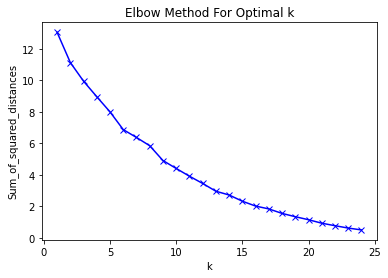

In [65]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
mms = MinMaxScaler()
mms.fit(ottawa_grouped_clustering)
data_transformed = mms.transform(ottawa_grouped_clustering)

Sum_of_squared_distances = []
K = range(1,25)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(ottawa_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [66]:
# add clustering labels
ottawa_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans2.labels_)

ottawa_merged = df_ottawa

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
ottawa_merged = ottawa_merged.join(ottawa_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ottawa_merged.head() # check the last columns!

,Postal Code,City,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,K2A,Ottawa,"Highland Park, McKellar Park,Westboro, Glabar ...",45.195828,-75.823060,2.0,Garden,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Yoga Studio
1,K4A,Ottawa,Fallingbrook,45.449549,-75.476860,1.0,Construction & Landscaping,Pharmacy,Sports Club,Yoga Studio,Fast Food Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
2,K1B,Ottawa,"Blackburn Hamlet, Pine View, Sheffield Glen",45.416035,-75.621899,13.0,Shop & Service,Electronics Store,Yoga Studio,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop
3,K2B,Ottawa,"Britannia, Whitehaven, Bayshore, Pinecrest",45.351891,-75.790968,12.0,Coffee Shop,Bus Station,Bookstore,Shoe Store,Gym,Department Store,Pizza Place,Food & Drink Shop,Frozen Yogurt Shop,Fried Chicken Joint
4,K4B,Ottawa,Navan,45.425883,-75.507849,4.0,Waste Facility,Garden Center,Yoga Studio,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court


In [67]:
ottawa_merged.dropna(inplace=True)

# create map
ottawa_map_clusters = folium.Map(location=[45.449549,-75.476860], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters2)
ys = [i + x + (i*x)**2 for i in range(kclusters2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ottawa_merged['Latitude'], ottawa_merged['Longitude'], ottawa_merged['Neighborhood'], ottawa_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(ottawa_map_clusters)
       
ottawa_map_clusters

#### Examining the Ottawa clusters

In [68]:
# cluster 1
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 0, ottawa_merged.columns[[1] + list(range(5, ottawa_merged.shape[1]))]]

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Ottawa,0.0,Pizza Place,Pharmacy,Train Station,Grocery Store,Yoga Studio,Farmers Market,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
36,Ottawa,0.0,Pizza Place,Grocery Store,Arts & Crafts Store,Spa,Gourmet Shop,Pharmacy,Hobby Shop,Deli / Bodega,Restaurant,Fast Food Restaurant


In [69]:
# cluster 2
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 1, ottawa_merged.columns[[1] + list(range(5, ottawa_merged.shape[1]))]]

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Ottawa,1.0,Construction & Landscaping,Pharmacy,Sports Club,Yoga Studio,Fast Food Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
5,Ottawa,1.0,Construction & Landscaping,Yoga Studio,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop


In [70]:
# cluster 3
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 2, ottawa_merged.columns[[1] + list(range(5, ottawa_merged.shape[1]))]]

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ottawa,2.0,Garden,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Yoga Studio
6,Ottawa,2.0,Garden,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Yoga Studio


In [71]:
# cluster 4
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 3, ottawa_merged.columns[[1] + list(range(5, ottawa_merged.shape[1]))]]

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Ottawa,3.0,Cosmetics Shop,Home Service,Yoga Studio,Farmers Market,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop


In [72]:
# cluster 5
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 4, ottawa_merged.columns[[1] + list(range(5, ottawa_merged.shape[1]))]]

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Ottawa,4.0,Waste Facility,Garden Center,Yoga Studio,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court


In [73]:
# cluster 6
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 5, ottawa_merged.columns[[1] + list(range(5, ottawa_merged.shape[1]))]]

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Ottawa,5.0,Campground,Yoga Studio,Curling Ice,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop


In [74]:
# cluster 7
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 6, ottawa_merged.columns[[1] + list(range(5, ottawa_merged.shape[1]))]]

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Ottawa,6.0,Boat or Ferry,Yoga Studio,Garden Center,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop


In [75]:
# cluster 8
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 7, ottawa_merged.columns[[1] + list(range(5, ottawa_merged.shape[1]))]]

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Ottawa,7.0,Bus Station,Park,Food & Drink Shop,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court


In [76]:
# cluster 9
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 8, ottawa_merged.columns[[1] + list(range(5, ottawa_merged.shape[1]))]]

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
38,Ottawa,8.0,Playground,Sculpture Garden,Yoga Studio,Farmers Market,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop


In [77]:
# cluster 10
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 9, ottawa_merged.columns[[1] + list(range(5, ottawa_merged.shape[1]))]]

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Ottawa,9.0,Furniture / Home Store,Grocery Store,Yoga Studio,Garden Center,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop


In [78]:
# cluster 11
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 10, ottawa_merged.columns[[1] + list(range(5, ottawa_merged.shape[1]))]]

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Ottawa,10.0,Clothing Store,Trail,Farmers Market,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop


In [79]:
# cluster 12
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 11, ottawa_merged.columns[[1] + list(range(5, ottawa_merged.shape[1]))]]

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Ottawa,11.0,Theme Park,Yoga Studio,Garden Center,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop


In [80]:
# cluster 13
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 12, ottawa_merged.columns[[1] + list(range(5, ottawa_merged.shape[1]))]]

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Ottawa,12.0,Coffee Shop,Bus Station,Bookstore,Shoe Store,Gym,Department Store,Pizza Place,Food & Drink Shop,Frozen Yogurt Shop,Fried Chicken Joint
10,Ottawa,12.0,Shoe Store,Sporting Goods Shop,Liquor Store,Hotel,Coffee Shop,Clothing Store,Food & Drink Shop,Department Store,Gas Station,Grocery Store
11,Ottawa,12.0,Liquor Store,Auto Garage,Food Truck,Clothing Store,Hardware Store,Park,Furniture / Home Store,Discount Store,Dive Bar,Diner
15,Ottawa,12.0,Coffee Shop,Chinese Restaurant,Restaurant,Bank,Beer Store,Café,Food Court,Sandwich Place,Liquor Store,Swiss Restaurant
17,Ottawa,12.0,Gym / Fitness Center,Indian Restaurant,Bakery,Coffee Shop,Sandwich Place,Café,Dance Studio,Breakfast Spot,Sushi Restaurant,Bar
19,Ottawa,12.0,Pool,Dance Studio,Supermarket,Chinese Restaurant,Optical Shop,Fast Food Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
20,Ottawa,12.0,Restaurant,Park,Scenic Lookout,Fast Food Restaurant,Yoga Studio,Farmers Market,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
23,Ottawa,12.0,Pub,Café,New American Restaurant,Dessert Shop,Coffee Shop,Ice Cream Shop,BBQ Joint,Furniture / Home Store,Vietnamese Restaurant,Mexican Restaurant
24,Ottawa,12.0,Coffee Shop,Restaurant,Sandwich Place,Café,Hotel,Japanese Restaurant,Sushi Restaurant,Salad Place,Food Truck,Concert Hall
25,Ottawa,12.0,Coffee Shop,Café,Restaurant,Japanese Restaurant,Food Truck,Concert Hall,Bank,Salad Place,Italian Restaurant,Sandwich Place


In [81]:
# cluster 14
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 13, ottawa_merged.columns[[1] + list(range(5, ottawa_merged.shape[1]))]]

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Ottawa,13.0,Shop & Service,Electronics Store,Yoga Studio,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop


In [82]:
# cluster 15
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 14, ottawa_merged.columns[[1] + list(range(5, ottawa_merged.shape[1]))]]

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Ottawa,14.0,Motorcycle Shop,Athletics & Sports,Food & Drink Shop,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court


In [83]:
# cluster 16
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 15, ottawa_merged.columns[[1] + list(range(5, ottawa_merged.shape[1]))]]

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Ottawa,15.0,Home Service,Yoga Studio,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop


In [84]:
# cluster 17
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 16, ottawa_merged.columns[[1] + list(range(5, ottawa_merged.shape[1]))]]

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Ottawa,16.0,Business Service,Home Service,Construction & Landscaping,Grocery Store,Food & Drink Shop,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck


# Question 2 - Italian Restaurants in Toronto

Objective: A restaurant owner is looking to open a new Italian restaurant in Toronto, the objective is to recommend the best location to open the venue.

#### Defining Foursquare credentials

In [85]:
CLIENT_ID = 'XBAJLFUBKHRRDCJOZ3PGS4R2EOIDLVOGMCX5PKJJK3HXXQHN' # your Foursquare ID
CLIENT_SECRET = 'XCXXBLEAC1JRK1TA2URBNDK2INZO4VT5RIZB0EUUBU2ALIDX' # your Foursquare Secret
ACCESS_TOKEN = '3JOP5NNXTMI35QWWSNTJPCRLNV02BPU3VQ4122VZ4YPOBM5C'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XBAJLFUBKHRRDCJOZ3PGS4R2EOIDLVOGMCX5PKJJK3HXXQHN
CLIENT_SECRET:XCXXBLEAC1JRK1TA2URBNDK2INZO4VT5RIZB0EUUBU2ALIDX


#### Converting Toronto into lat long using geocoder

In [86]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

43.6534817 -79.3839347


In [87]:
search_query = 'Italian'
radius = 10000
print(search_query + ' .... OK!')

Italian .... OK!


In [88]:
url3 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
url3

'https://api.foursquare.com/v2/venues/search?client_id=XBAJLFUBKHRRDCJOZ3PGS4R2EOIDLVOGMCX5PKJJK3HXXQHN&client_secret=XCXXBLEAC1JRK1TA2URBNDK2INZO4VT5RIZB0EUUBU2ALIDX&ll=43.6534817,-79.3839347&oauth_token=3JOP5NNXTMI35QWWSNTJPCRLNV02BPU3VQ4122VZ4YPOBM5C&v=20180605&query=Italian&radius=10000&limit=100'

In [89]:
results3 = requests.get(url3).json()
results3

{'meta': {'code': 200, 'requestId': '602ba260f3484c1e4214bd71'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venues': [{'id': '5b897e92db1d81002c91df8c',
    'name': 'Fabbrica Rustic Italian',
    'location': {'address': '66 Wellington St W',
     'lat': 43.647161,
     'lng': -79.381691,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.647161,
       'lng': -79.381691}],
     'distance': 726,
     'postalCode': 'M5K 1E7',
     'cc': 'CA',
     'city': 'Toronto',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['66 Wellington St W',
      'Toronto ON M5K 1E7',
      'Canada']},
    'categories': [{'id': '4bf58dd8d48988d110941735',
      'name': 'Italian Restaurant',
      'pluralName': 'Italian Restaurants',
      'shortName': 'Italian',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1613472352',
 

In [90]:
# assign relevant part of JSON to venues
venues = results3['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,location.neighborhood,venuePage.id
0,5b897e92db1d81002c91df8c,Fabbrica Rustic Italian,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",v-1613472352,False,66 Wellington St W,43.647161,-79.381691,"[{'label': 'display', 'lat': 43.647161, 'lng':...",726,M5K 1E7,CA,Toronto,ON,Canada,"[66 Wellington St W, Toronto ON M5K 1E7, Canada]",NaN,NaN,NaN
1,52f6816f11d24a43115dc834,Scaddabush Italian Kitchen & Bar,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",v-1613472352,False,"382 Yonge Street, Unit #7",43.658920,-79.382891,"[{'label': 'display', 'lat': 43.65892029202872...",611,M5B 1S8,CA,Toronto,ON,Canada,"[382 Yonge Street, Unit #7 (Gerrard), Toronto ...",Gerrard,NaN,NaN
2,573df789498e03dd8e54b166,Mustachio Italian Eatery,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",v-1613472352,False,595 Bay St,43.656160,-79.383190,"[{'label': 'display', 'lat': 43.65616, 'lng': ...",304,M5G 2C2,CA,Toronto,ON,Canada,"[595 Bay St (Dundas St), Toronto ON M5G 2C2, C...",Dundas St,NaN,NaN
3,4c787c9181bca0936180fa14,Classic italian style pizza food truck,"[{'id': '4bf58dd8d48988d1cb941735', 'name': 'F...",v-1613472352,False,CNE Midway,43.652144,-79.381118,"[{'label': 'display', 'lat': 43.652144, 'lng':...",271,NaN,CA,Toronto,ON,Canada,"[CNE Midway, Toronto ON, Canada]",NaN,NaN,NaN
4,5e594c8a3de308000870c948,Elm Street Italian Deli,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",v-1613472352,False,15 Elm Street,43.657690,-79.382480,"[{'label': 'display', 'lat': 43.65769, 'lng': ...",482,M5G 1G7,CA,Toronto,ON,Canada,"[15 Elm Street, Toronto ON M5G 1G7, Canada]",NaN,NaN,NaN


In [91]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Fabbrica Rustic Italian,Italian Restaurant,66 Wellington St W,43.647161,-79.381691,"[{'label': 'display', 'lat': 43.647161, 'lng':...",726,M5K 1E7,CA,Toronto,ON,Canada,"[66 Wellington St W, Toronto ON M5K 1E7, Canada]",NaN,NaN,5b897e92db1d81002c91df8c
1,Scaddabush Italian Kitchen & Bar,Italian Restaurant,"382 Yonge Street, Unit #7",43.658920,-79.382891,"[{'label': 'display', 'lat': 43.65892029202872...",611,M5B 1S8,CA,Toronto,ON,Canada,"[382 Yonge Street, Unit #7 (Gerrard), Toronto ...",Gerrard,NaN,52f6816f11d24a43115dc834
2,Mustachio Italian Eatery,Italian Restaurant,595 Bay St,43.656160,-79.383190,"[{'label': 'display', 'lat': 43.65616, 'lng': ...",304,M5G 2C2,CA,Toronto,ON,Canada,"[595 Bay St (Dundas St), Toronto ON M5G 2C2, C...",Dundas St,NaN,573df789498e03dd8e54b166
3,Classic italian style pizza food truck,Food Truck,CNE Midway,43.652144,-79.381118,"[{'label': 'display', 'lat': 43.652144, 'lng':...",271,NaN,CA,Toronto,ON,Canada,"[CNE Midway, Toronto ON, Canada]",NaN,NaN,4c787c9181bca0936180fa14
4,Elm Street Italian Deli,Italian Restaurant,15 Elm Street,43.657690,-79.382480,"[{'label': 'display', 'lat': 43.65769, 'lng': ...",482,M5G 1G7,CA,Toronto,ON,Canada,"[15 Elm Street, Toronto ON M5G 1G7, Canada]",NaN,NaN,5e594c8a3de308000870c948
5,"Punto Gelato, Simply Italian",Ice Cream Shop,146 Cumberland St,43.669955,-79.392603,"[{'label': 'display', 'lat': 43.66995452843031...",1962,M5R 1A8,CA,Toronto,ON,Canada,"[146 Cumberland St (btwn Avenue Rd & Bay St), ...",btwn Avenue Rd & Bay St,Yorkville,4e31afdd091a973ec9c5a2b5
6,The Fresh Italian,Italian Restaurant,NaN,43.654991,-79.387897,"[{'label': 'display', 'lat': 43.65499143746528...",360,NaN,CA,Toronto,ON,Canada,"[Toronto ON, Canada]",NaN,NaN,51bf3866498e55ee55df8db0
7,LA's Italian + Bar,Italian Restaurant,NaN,43.650540,-79.384603,"[{'label': 'display', 'lat': 43.65053979517576...",331,NaN,CA,NaN,NaN,Canada,[Canada],NaN,NaN,4f88cf84e4b002b90ab3b9b9
8,Italian Consulate Toronto,Embassy / Consulate,136 Beverley St,43.654027,-79.394104,"[{'label': 'display', 'lat': 43.65402694219784...",821,NaN,CA,Toronto,ON,Canada,"[136 Beverley St (Dundas Street), Toronto ON, ...",Dundas Street,NaN,4bfc0289c3ba9521c00f9653
9,The Fresh Italian Eatery,Italian Restaurant,"109 McCaul Street, Unit #42",43.653889,-79.390785,"[{'label': 'display', 'lat': 43.653889, 'lng':...",553,M5T 3K5,CA,Toronto,ON,Canada,"[109 McCaul Street, Unit #42 (Dundas Street We...",Dundas Street West,NaN,526fe29411d2aeb3803013b0


In [92]:
venues_map = folium.Map(location=[43.6534817,-79.3839347], zoom_start=12) # generate map centred around Toronto

# add a red circle marker to represent Toronto
folium.CircleMarker(
    [43.6534817,-79.3839347],
    radius=10,
    color='red',
    popup='Toronto',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map